---------------------------------------------------------------------------------------
## Import libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,DepthwiseConv2D
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.listdir("../input"))

['fer2013.csv']


## Dataset Overview

In [ ]:
data = pd.read_csv('../input/fer2013.csv')
#check data shape
data.shape

(35887, 3)

In [ ]:
#preview first 5 row of data
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
#check usage values
#80% training, 10% validation and 10% test
data.Usage.value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [ ]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


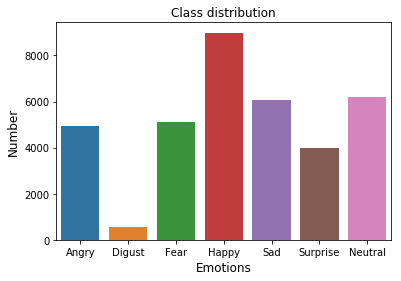

In [ ]:
# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

#image samples

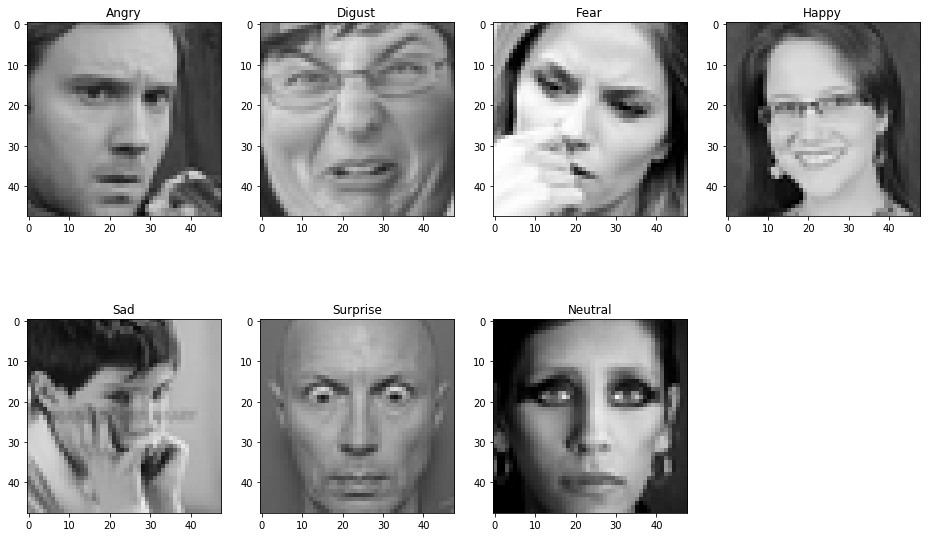

In [ ]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(224,224)
    image = np.zeros((224,224,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()  

----------------------------------------------------------------------------------
## Pre-processing data

1. Splitting dataset into 3 parts: train, validation, test
1. Convert strings to lists of integers
1. Reshape and normalise grayscale image with 255.0
1. Perform one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

In [ ]:
#split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


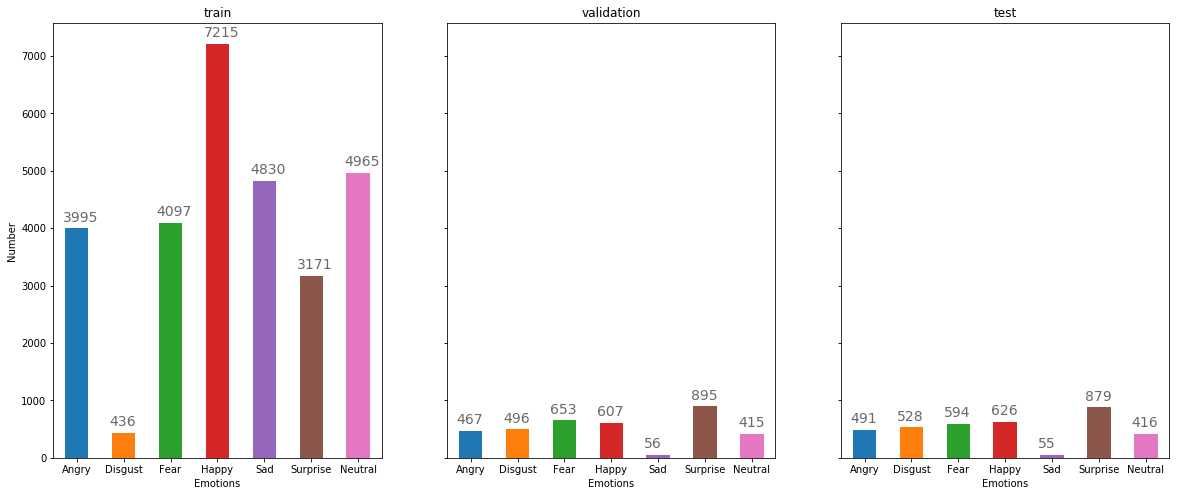

In [ ]:
# barplot class distribution of train, val and test
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

   
fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

In [ ]:
#initilize parameters
num_classes = 7 
width, height = 224, 224
num_epochs = 50
batch_size = 64
num_features = 64

In [ ]:
#Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

In [ ]:
model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 256)       2560      
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 256)       590080    
_________________________________________________________________
batch_normalization_2 (Batch (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_2 (Activation)    (None, 46, 46, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 256)       0         
__________

In [ ]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

Epoch 1/50
 - 36s - loss: 1.7149 - acc: 0.3161 - val_loss: 1.6494 - val_acc: 0.3686
Epoch 2/50
 - 30s - loss: 1.4178 - acc: 0.4536 - val_loss: 1.7658 - val_acc: 0.3505
Epoch 3/50
 - 30s - loss: 1.2661 - acc: 0.5142 - val_loss: 1.2313 - val_acc: 0.5358
Epoch 4/50
 - 30s - loss: 1.1885 - acc: 0.5488 - val_loss: 1.3933 - val_acc: 0.4960
Epoch 5/50
 - 30s - loss: 1.1341 - acc: 0.5708 - val_loss: 1.1832 - val_acc: 0.5548
Epoch 6/50
 - 30s - loss: 1.0935 - acc: 0.5841 - val_loss: 1.2068 - val_acc: 0.5428
Epoch 7/50
 - 30s - loss: 1.0673 - acc: 0.5949 - val_loss: 1.1894 - val_acc: 0.5637
Epoch 8/50
 - 30s - loss: 1.0341 - acc: 0.6086 - val_loss: 1.0959 - val_acc: 0.5862
Epoch 9/50
 - 30s - loss: 1.0112 - acc: 0.6171 - val_loss: 1.0910 - val_acc: 0.5907
Epoch 10/50
 - 30s - loss: 0.9866 - acc: 0.6270 - val_loss: 1.0999 - val_acc: 0.5910
Epoch 11/50
 - 30s - loss: 0.9703 - acc: 0.6368 - val_loss: 1.1257 - val_acc: 0.5979
Epoch 12/50
 - 30s - loss: 0.9516 - acc: 0.6383 - val_loss: 1.1183 - val_a

In [ ]:
model.save_weights("./modelumair111.h5")

## Visualize Training Performance

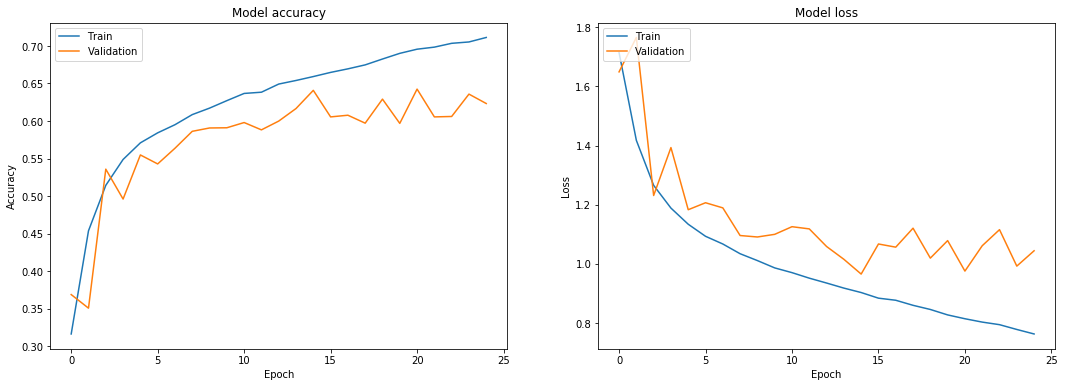

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['acc'])
axes[0].plot(history.history['val_acc'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Evaluate Test Performance

In [ ]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

CNN Model Accuracy on test set: 0.6459


## More Analysis using Confusion Matrix

Confusion Matrix is applied and plotted to find out which emotion usually get confused with each other.

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

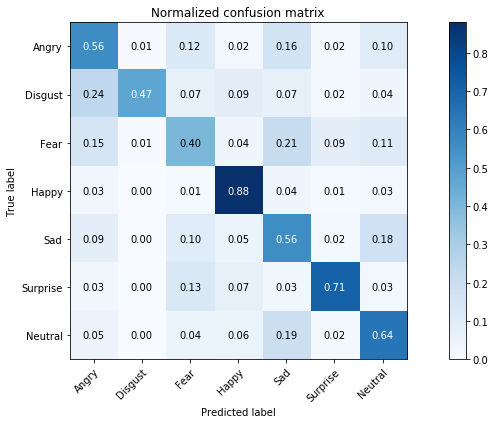

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
model2 = Sequential()

#module 1
model2.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model2.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(DepthwiseConv2D(kernel_size=(3, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Conv2D(2*num_features, kernel_size=(2, 2), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model2.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(DepthwiseConv2D(kernel_size=(3, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Conv2D(num_features, kernel_size=(2, 2), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model2.add(Flatten())

#dense 1
model2.add(Dense(2*2*2*num_features))
model2.add(BatchNormalization())
model2.add(Activation('relu'))

#dense 2
model2.add(Dense(2*2*num_features))
model2.add(BatchNormalization())
model2.add(Activation('relu'))

#dense 3
model2.add(Dense(2*num_features))
model2.add(BatchNormalization())
model2.add(Activation('relu'))

#output layer
model2.add(Dense(num_classes, activation='softmax'))

model2.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 46, 46, 256)       2560      
_________________________________________________________________
batch_normalization_28 (Batc (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_28 (Activation)   (None, 46, 46, 256)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 46, 46, 256)       590080    
_________________________________________________________________
batch_normalization_29 (Batc (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_29 (Activation)   (None, 46, 46, 256)       0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 23, 23, 256)       0         
__________

In [ ]:
history2 = model2.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

Epoch 1/50
 - 35s - loss: 1.6866 - acc: 0.3298 - val_loss: 1.5553 - val_acc: 0.3895
Epoch 2/50
 - 31s - loss: 1.4172 - acc: 0.4498 - val_loss: 1.6831 - val_acc: 0.3636
Epoch 3/50
 - 31s - loss: 1.2647 - acc: 0.5148 - val_loss: 1.3671 - val_acc: 0.4745
Epoch 4/50
 - 31s - loss: 1.1868 - acc: 0.5467 - val_loss: 1.2463 - val_acc: 0.5283
Epoch 5/50
 - 31s - loss: 1.1347 - acc: 0.5695 - val_loss: 1.1843 - val_acc: 0.5422
Epoch 6/50
 - 31s - loss: 1.0990 - acc: 0.5850 - val_loss: 1.2391 - val_acc: 0.5467
Epoch 7/50
 - 31s - loss: 1.0667 - acc: 0.5955 - val_loss: 1.1422 - val_acc: 0.5639
Epoch 8/50
 - 31s - loss: 1.0423 - acc: 0.6046 - val_loss: 1.0614 - val_acc: 0.6004
Epoch 9/50
 - 31s - loss: 1.0185 - acc: 0.6108 - val_loss: 1.2057 - val_acc: 0.5464
Epoch 10/50
 - 31s - loss: 0.9934 - acc: 0.6230 - val_loss: 1.0524 - val_acc: 0.6041
Epoch 11/50
 - 31s - loss: 0.9756 - acc: 0.6294 - val_loss: 1.0993 - val_acc: 0.6043
Epoch 12/50
 - 31s - loss: 0.9571 - acc: 0.6361 - val_loss: 1.0776 - val_a

In [ ]:
model2.save_weights("./modelumair222.h5")

In [ ]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model2.predict(test_X), axis=1)
print("Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

Model Accuracy on test set: 0.6645


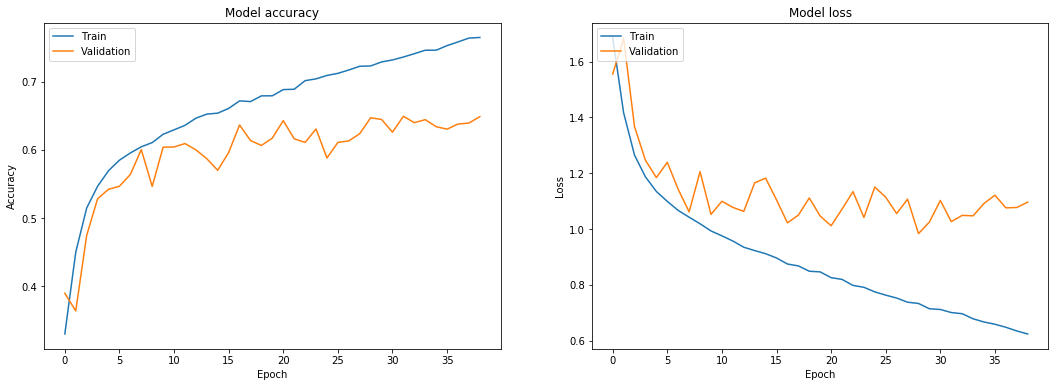

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history2.history['acc'])
axes[0].plot(history2.history['val_acc'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history2.history['loss'])
axes[1].plot(history2.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model3 = Sequential()

#module 1
model3.add(DepthwiseConv2D(kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model3.add(DepthwiseConv2D(kernel_size=(3, 3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Conv2D(6*num_features, kernel_size=(2, 2), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model3.add(DepthwiseConv2D(kernel_size=(3, 3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Conv2D(3*num_features, kernel_size=(2, 2), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model3.add(Flatten())

#dense 1
model3.add(Dense(2*2*2*num_features))
model3.add(BatchNormalization())
model3.add(Activation('relu'))

#dense 2
model3.add(Dense(2*2*num_features))
model3.add(BatchNormalization())
model3.add(Activation('relu'))

#dense 3
model3.add(Dense(2*num_features))
model3.add(BatchNormalization())
model3.add(Activation('relu'))

#output layer
model3.add(Dense(num_classes, activation='softmax'))

model3.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
depthwise_conv2d_12 (Depthwi (None, 46, 46, 1)         10        
_________________________________________________________________
batch_normalization_66 (Batc (None, 46, 46, 1)         4         
_________________________________________________________________
activation_66 (Activation)   (None, 46, 46, 1)         0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 46, 46, 256)       2560      
_________________________________________________________________
batch_normalization_67 (Batc (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_67 (Activation)   (None, 46, 46, 256)       0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 23, 23, 256)       0         
__________

In [ ]:
history3 = model3.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

Epoch 1/50
 - 27s - loss: 1.6355 - acc: 0.3598 - val_loss: 1.5484 - val_acc: 0.4213
Epoch 2/50
 - 22s - loss: 1.3754 - acc: 0.4716 - val_loss: 1.6255 - val_acc: 0.4074
Epoch 3/50
 - 22s - loss: 1.2628 - acc: 0.5163 - val_loss: 1.5353 - val_acc: 0.4374
Epoch 4/50
 - 22s - loss: 1.1984 - acc: 0.5400 - val_loss: 1.2974 - val_acc: 0.5060
Epoch 5/50
 - 23s - loss: 1.1471 - acc: 0.5617 - val_loss: 1.2643 - val_acc: 0.5163
Epoch 6/50
 - 22s - loss: 1.1132 - acc: 0.5767 - val_loss: 1.3868 - val_acc: 0.4893
Epoch 7/50
 - 23s - loss: 1.0813 - acc: 0.5905 - val_loss: 1.2618 - val_acc: 0.5467
Epoch 8/50
 - 23s - loss: 1.0537 - acc: 0.6024 - val_loss: 1.1831 - val_acc: 0.5653
Epoch 9/50
 - 22s - loss: 1.0311 - acc: 0.6087 - val_loss: 1.1908 - val_acc: 0.5578
Epoch 10/50


In [ ]:
model3.save_weights("./modelumair333.h5")

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history3.history['acc'])
axes[0].plot(history3.history['val_acc'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history3.history['loss'])
axes[1].plot(history3.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model3.predict(test_X), axis=1)
print("Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))